# Домашнее задание по теме "Рекомендации на основе содержания"

**Цель работы:**  
На основе предсказанных оценок сделать подборку фильмов конкретному юзеру.


**Задачи работы:**  
1. ***Построить рекомендации на фичах:***
        - TF-IDF на тегах и жанрах  
        - Средние оценки (+ медиана, дисперсия и т.п.) пользователя фильма   
             
             
2. ***Оценить RMSE на тестовой выборке***

**План работы:**
1. Выгрузить и проанализировать данные  
2. Cгенерировать новый признак и объединить таблицы в одну
3. Сделать TF-IDF-преобразование и собрать датасет  
4. Обучить модель
5. Сделать выводы

### 1. Предобработка данных и EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [3]:
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import mean_squared_error

In [4]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

Теперь напишем функцию, которая на выходе будет показывать основную информацию о файлах: их размер, статистику, количество пропусков, info файла, графики взаимозависимостей признаков и первые 5 строк файла:

In [5]:
def info(data):
    shape = data.shape
    isna = data.isna().sum()
    desc = data.describe()
    head = data.head()
    print('\033[1m' + 'data shape: ' + '\033[0m', shape, ' \n')
    print('\033[1m' +  'data describe: ' + '\033[0m', '\n ', desc, ' \n')
    print('\033[1m' +  'data isna: ' + '\033[0m', '\n ', isna, ' \n') 
    print('\033[1m' +  'data info: ' + '\033[0m')
    info = data.info()
    print()
    sns.pairplot(data)
    plt.show()
    print('\033[1m' +  'data head: ' + '\033[0m')
    return head

<u/>Начнем с links:</u>

data shape:  (9742, 3)  

data describe:  
               movieId        imdbId         tmdbId
count    9742.000000  9.742000e+03    9734.000000
mean    42200.353623  6.771839e+05   55162.123793
std     52160.494854  1.107228e+06   93653.481487
min         1.000000  4.170000e+02       2.000000
25%      3248.250000  9.518075e+04    9665.500000
50%      7300.000000  1.672605e+05   16529.000000
75%     76232.000000  8.055685e+05   44205.750000
max    193609.000000  8.391976e+06  525662.000000  

data isna:  
  movieId    0
imdbId     0
tmdbId     8
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB



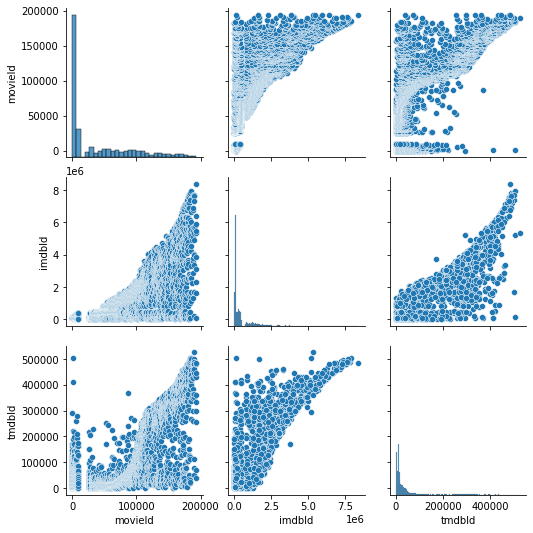

data head: 


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
info(links)

Сразу бросается в глаза наличие 8 пропусков в столбце "tmdbId". Стоит ли нам их заполнять? В идеале - стоит, однако ответим на вопрос, что содержит в себе эта таблица? Это просто уникальные id фильмов и их же id на популярных сайтах imdb и tmdb.  
Помогут ли они в предсказании оптимального фильма для рекомендации? Вряд ли. По сути это индексы. "Отложим" эту таблицу и перейдем к следующей.

<u/>movies:</u>

data shape:  (9742, 3)  

data describe:  
               movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000  

data isna:  
  movieId    0
title      0
genres     0
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB



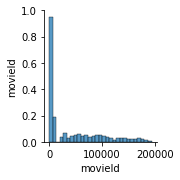

data head: 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
info(movies)

Это нужный файл. С ним поработаем отдельно. Как мы видим, 2 столбца из 3-х имеют тип данных object. Именно их нужно будет преобразовать. Также стоит отметить, что большая часть id сосредоточена ближе к нулю (см. гистограммму). Количество строк совпадает с файлом links.

<u/>ratings:</u>

data shape:  (100836, 4)  

data describe:  
                userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09  

data isna:  
  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-nu

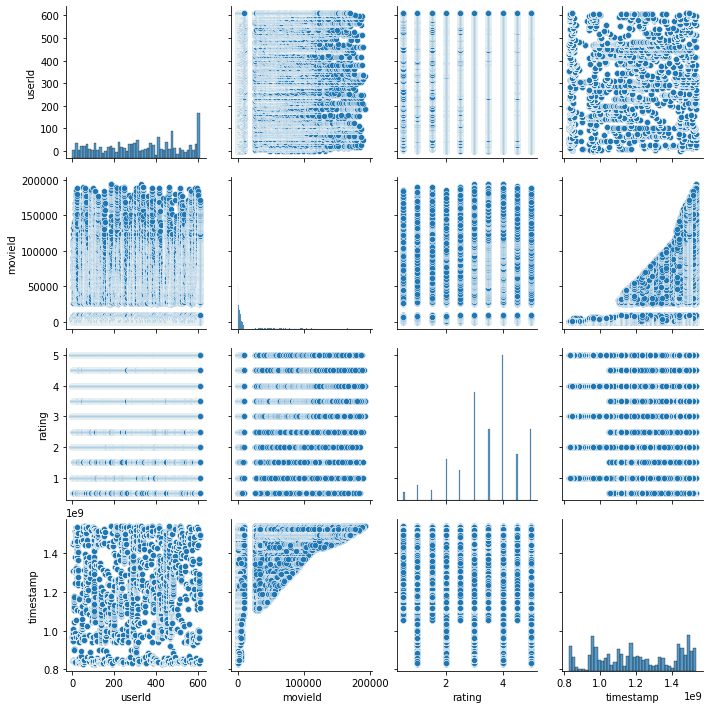

data head: 


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
info(ratings)

In [9]:
date = [datetime.datetime.fromtimestamp(ratings['timestamp'][i]).date() for i in range(len(ratings['timestamp']))]

Пропусков нет, и это хорошо. ID, что представлены здесь, нам понадобятся. Рейтинг - одна из самых нужных фичей. Насколько важен столбец со временем - посмотрим в перспективе.  

Коротко о столбцах рейтинга и времени:  
timestamp. Мы видим на диаграмме, что время представлено скачкообразно. Посмотрим поближе:

In [10]:
date = [datetime.datetime.fromtimestamp(ratings['timestamp'][i]).date() for i in range(len(ratings['timestamp']))]

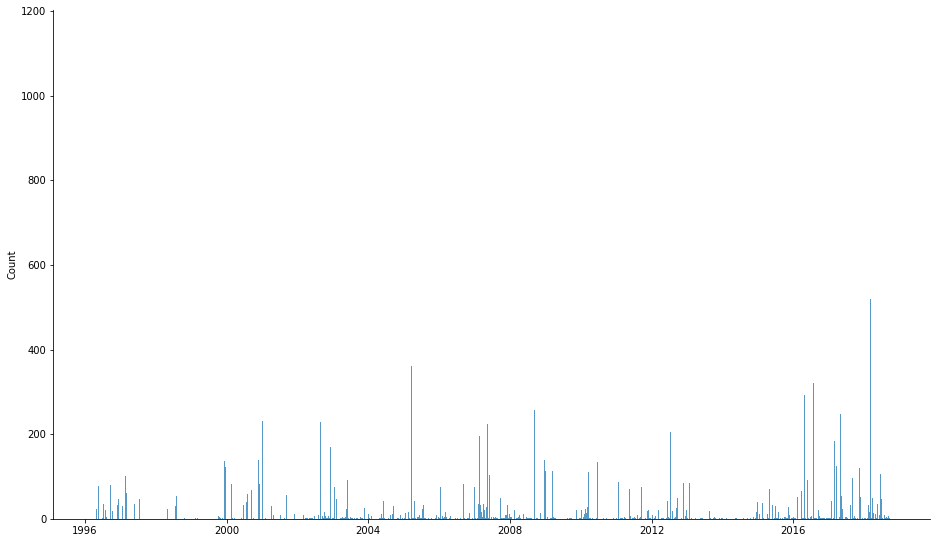

In [11]:
g=sns.displot(date)
g.fig.set_size_inches(15,8)

Пока можно сказать только, что оценок после 2016 года стало намного больше. Разобьем по годам и посмотрим предметнее:

In [12]:
date[0].year

2000

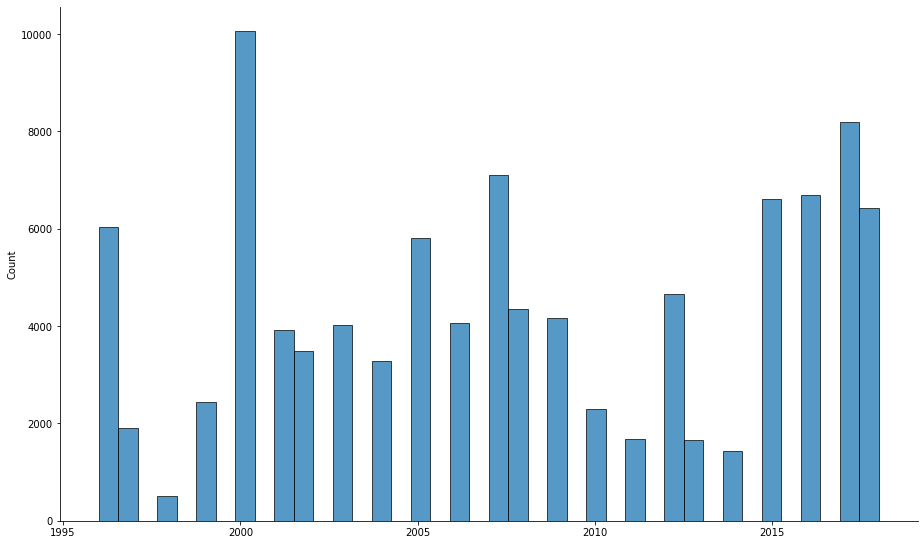

In [13]:
g=sns.displot([i.year for i in date])
g.fig.set_size_inches(15,8)

А вот и нет. Получается, 2000 год был более плодотворный на отзывы. А какой месяц является самым активным за весь период?

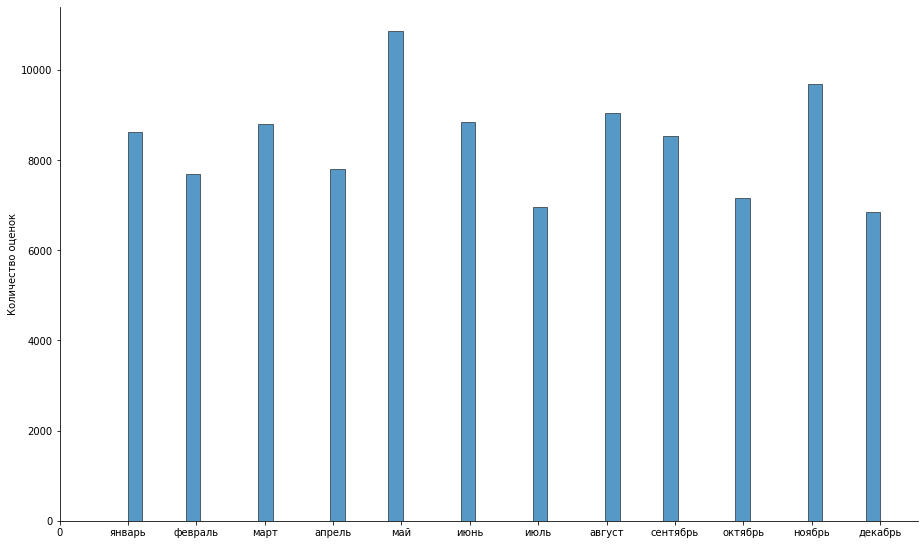

In [14]:
g=sns.displot([m.month for m in date])
plt.xticks(range(13), [0, 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 
                   'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.ylabel('Количество оценок')
g.fig.set_size_inches(15,8)

Больше всего оценок в мае. Далее - ноябрь. Вероятно, это самое популярное время премьер кинофильмов.  

Посмортим поближе на 2000 год: какой месяц был здесь самым активным?

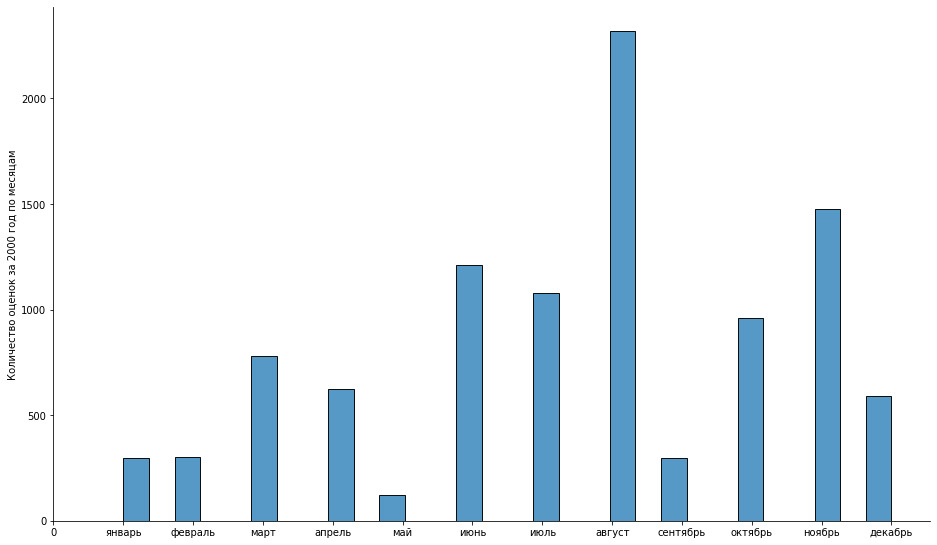

In [15]:
year_2000 = [i for i in date if i.year == 2000]

g=sns.displot([m.month for m in year_2000])
plt.xticks(range(13), [0, 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 
                   'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.ylabel('Количество оценок за 2000 год по месяцам')
g.fig.set_size_inches(15,8)

Картина несколько изменилась: теперь в фаворе август. Остальные месяцы сильно отстают.  
    
Посмотрим теперь на дни месяца:

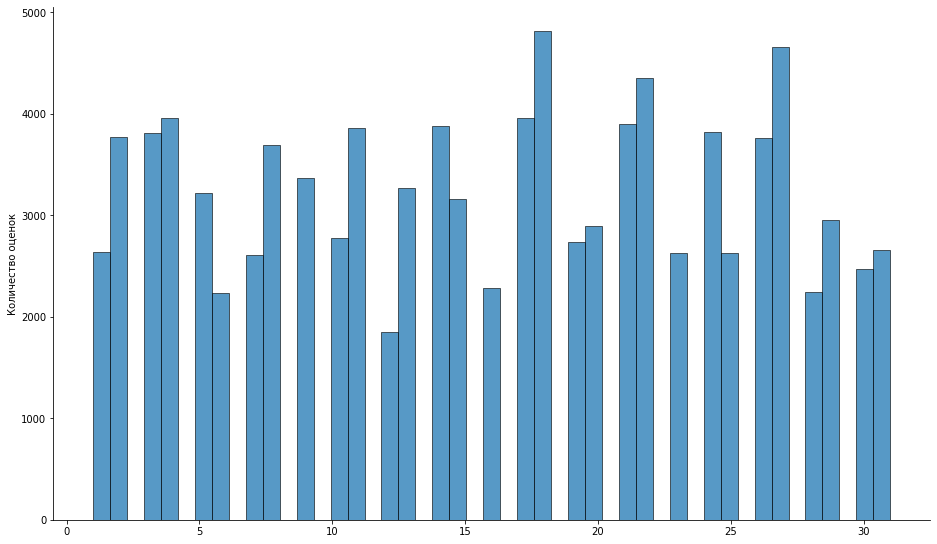

In [16]:
g=sns.displot([d.day for d in date])
plt.ylabel('Количество оценок')
g.fig.set_size_inches(15,8)

Любопытное наблюдение: во вторую половину месяца, как правило, голосуют чаще.

Теперь интересно взглянуть на дни недели по всей истории выставления оценок:

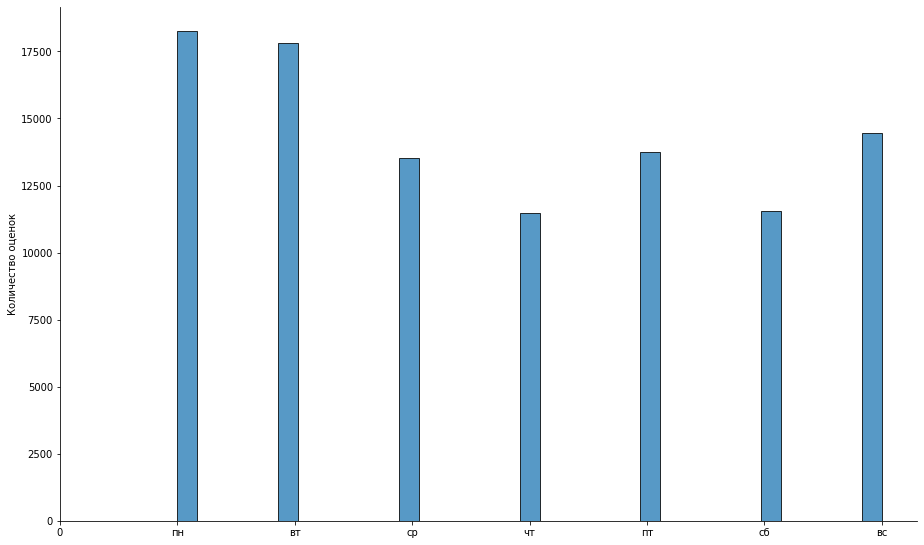

In [17]:
g=sns.displot([w.isoweekday() for w in date])
plt.xticks(range(8), [0, 'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.ylabel('Количество оценок')
g.fig.set_size_inches(15,8)

В целом в понедельник оценивали несколько чаще, чем в другие дни. Вероятно, отзыв писался (и оценка ставилась) на работе после посещения кинопремьеры в выходной))

Ок. Переходим к последнему столбцу - rating. Здесь не так много уникальных значений (судя по информации из describe).  
Посмотрим на график и посчитаем количество оценок:

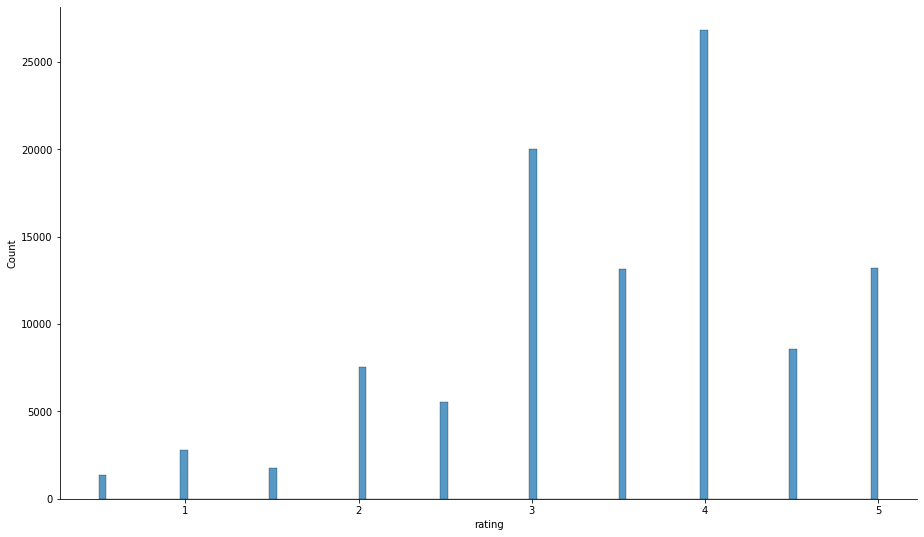

In [18]:
g=sns.displot(ratings['rating'])
g.fig.set_size_inches(15,8)

In [19]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

Самая частая оценка - 4.0. Вполне логично.

А какие оценки любят ставить в разные месяцы?

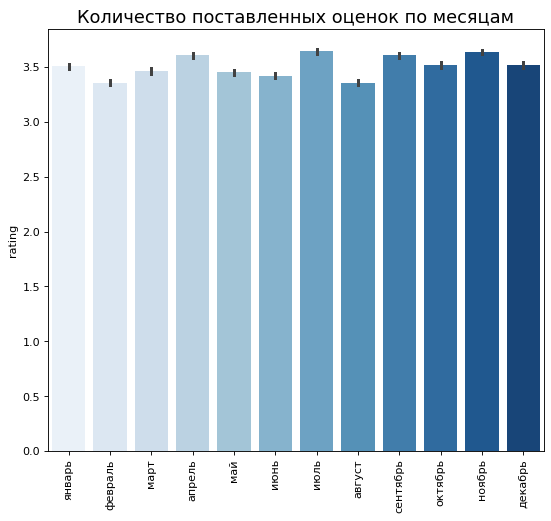

In [20]:
plt.figure(figsize=(8, 7), dpi=80)
sns.barplot(x=[m.month for m in date], y='rating', data=ratings, palette="Blues")
plt.title('Количество поставленных оценок по месяцам', fontsize=16)
plt.xticks(range(12), ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 
                   'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.xticks(rotation=90)
plt.show()

И снова видно, что в апреле, июле и ноябре несколько больше отзывов, чем в другие месяцы.  
Идем дальше.

In [21]:
del date

<u/>tags:</u>

data shape:  (3683, 4)  

data describe:  
              userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  1.137521e+09
50%     474.000000    4454.000000  1.269833e+09
75%     477.000000   39263.000000  1.498457e+09
max     610.000000  193565.000000  1.537099e+09  

data isna:  
  userId       0
movieId      0
tag          0
timestamp    0
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB



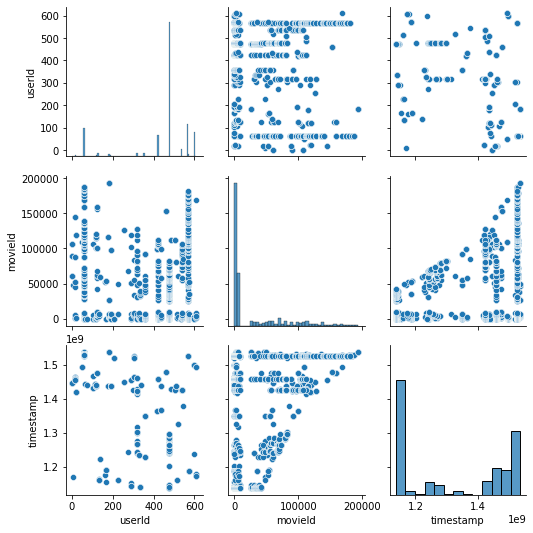

data head: 


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [22]:
info(tags)

И снова тут есть столбец "timestamp". Циклом пройдемся по нему и нагенерим признаков для тегов:

In [23]:
date = [datetime.datetime.fromtimestamp(tags['timestamp'][i]).date() for i in range(len(tags['timestamp']))]
date[-5:]

[datetime.date(2007, 2, 12),
 datetime.date(2007, 3, 9),
 datetime.date(2017, 5, 3),
 datetime.date(2017, 5, 3),
 datetime.date(2017, 5, 3)]

In [24]:
tags['year_tags'] = [i.year for i in date]
tags['month_tags'] = [i.month for i in date]
tags['day_tags'] = [i.day for i in date]
tags['day_of_week_tags'] = [i.isoweekday() for i in date]

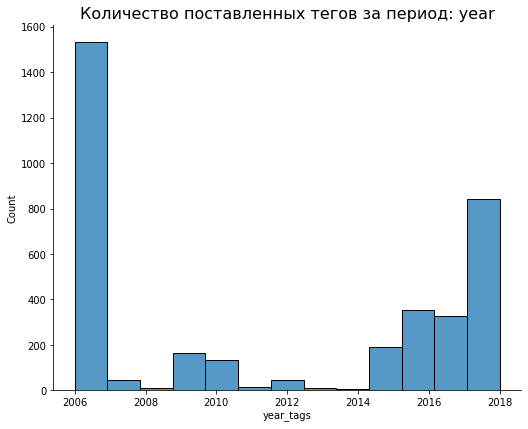

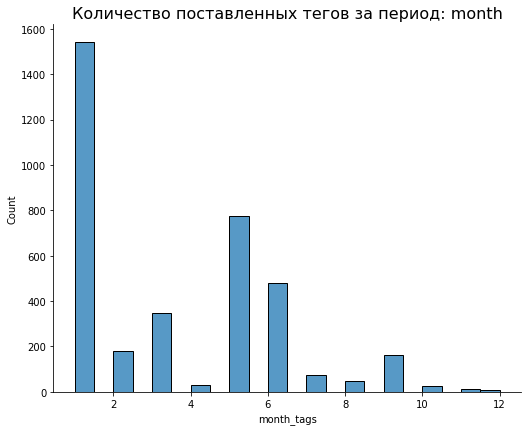

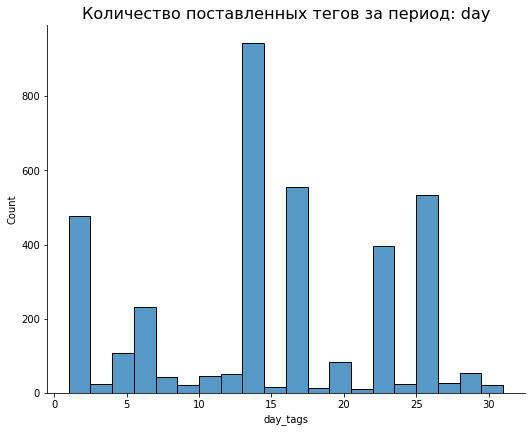

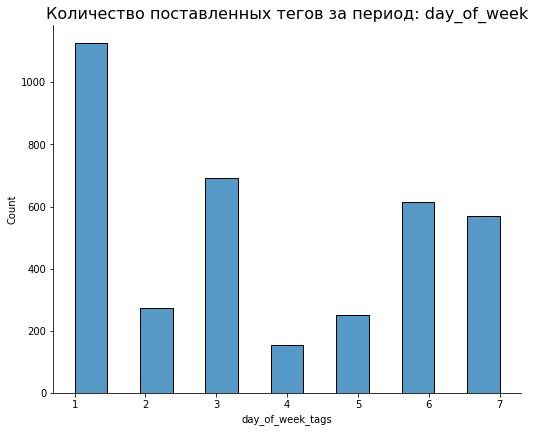

In [25]:
date_list = ['year_tags', 'month_tags', 'day_tags', 'day_of_week_tags']
for i in date_list:
    g=sns.displot(tags[i])
    plt.title('Количество поставленных тегов за период: {}'.format(i[:-5]), fontsize=16)
    g.fig.set_size_inches(8,6)
    plt.show()

Итак, больше всего тегов проставлено в 2006 году; если рассматривать месяцы - в январе; если рассматривать дни месяца - то, как и при выставлении рейтинга, активнее вторая половина месяца (точнее середина и далее); и если говорить о днях недели, то чаще всего тэги ставят тоже в понедельник. Получается, данные перекликаются, т.е. закономерности действительно присутствуют.

### 2. Объединение фреймов в один и генерация новых признаков

In [26]:
tags.shape, movies.shape, ratings.shape

((3683, 8), (9742, 3), (100836, 4))

Поскольку именно таблица с названиями фильмов является приоритетной, то присоединять другие таблицы будем именно к ней. Поэтому будем считать, что количество строк, равное 9742, - эталон.  
Работаем с таблицей ratings. Сначала сгруппируем данные по столбцу movieId:

In [27]:
new_ratings = ratings.groupby('movieId')['rating'].agg([np.mean, np.median, np.var, np.count_nonzero])
new_ratings = new_ratings.reset_index()
new_ratings.head()

,movieId,mean,median,var,count_nonzero
0,1,3.920930,4.0,0.696990,215.0
1,2,3.431818,3.5,0.777419,110.0
2,3,3.259615,3.0,1.112651,52.0
3,4,2.357143,3.0,0.726190,7.0
4,5,3.071429,3.0,0.822917,49.0


In [28]:
new_ratings.tail()

,movieId,mean,median,var,count_nonzero
9719,193581,4.0,4.0,NaN,1.0
9720,193583,3.5,3.5,NaN,1.0
9721,193585,3.5,3.5,NaN,1.0
9722,193587,3.5,3.5,NaN,1.0
9723,193609,4.0,4.0,NaN,1.0


проверка:

In [29]:
ratings[ratings['movieId'] == 193609]

,userId,movieId,rating,timestamp
51362,331,193609,4.0,1537157606


In [30]:
new_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        9724 non-null   int64  
 1   mean           9724 non-null   float64
 2   median         9724 non-null   float64
 3   var            6278 non-null   float64
 4   count_nonzero  9724 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 380.0 KB


Идем дальше. Сравним размер таблицы new_ratings с movies:

In [31]:
movies.shape

(9742, 3)

У 18 фильмов нет рейтинга. Что за фильмы?

In [32]:
without_rating = set(movies['movieId'].tolist()) - set(new_ratings['movieId'].tolist())
without_rating

{1076,
 2939,
 3338,
 3456,
 4194,
 5721,
 6668,
 6849,
 7020,
 7792,
 8765,
 25855,
 26085,
 30892,
 32160,
 32371,
 34482,
 85565}

In [33]:
movies.query('movieId in @without_rating')

,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War
4037,5721,"Chosen, The (1981)",Drama
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
4598,6849,Scrooge (1970),Drama|Fantasy|Musical
4704,7020,Proof (1991),Comedy|Drama|Romance
5020,7792,"Parallax View, The (1974)",Thriller


Запомним их. После перепроверим.

Объединяем таблицы по movieId:

In [34]:
new_movies = movies.merge(new_ratings, on='movieId', how='left')
new_movies

,movieId,title,genres,mean,median,var,count_nonzero
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,4.0,0.696990,215.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.5,0.777419,110.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.0,1.112651,52.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,3.0,0.726190,7.0
4,5,Father of the Bride Part II (1995),Comedy,3.071429,3.0,0.822917,49.0
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.000000,4.0,NaN,1.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.500000,3.5,NaN,1.0
9739,193585,Flint (2017),Drama,3.500000,3.5,NaN,1.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.500000,3.5,NaN,1.0


Перепроверим себя:

In [35]:
new_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        9742 non-null   int64  
 1   title          9742 non-null   object 
 2   genres         9742 non-null   object 
 3   mean           9724 non-null   float64
 4   median         9724 non-null   float64
 5   var            6278 non-null   float64
 6   count_nonzero  9724 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 608.9+ KB


Вернемся к пропускам. Обратим внимание на то, что в столбце с дисперсией больше всего пропусков. Это логично, т.к. какая может быть дисперсия, если оценка только одна? Такие строчки будут малоинформативны, поэтому еще раз посмотрим на них (перепроверим себя) и чуть позже всем скопом удалим строки с пропусками:

In [36]:
new_ratings[new_ratings['var'].isna()]   # проверка, когда дисперсия не посчиталась

,movieId,mean,median,var,count_nonzero
45,49,3.0,3.0,NaN,1.0
50,55,4.0,4.0,NaN,1.0
69,77,4.0,4.0,NaN,1.0
75,83,3.0,3.0,NaN,1.0
85,96,3.5,3.5,NaN,1.0
...,...,...,...,...,...
9719,193581,4.0,4.0,NaN,1.0
9720,193583,3.5,3.5,NaN,1.0
9721,193585,3.5,3.5,NaN,1.0
9722,193587,3.5,3.5,NaN,1.0


Идем дальше: сгруппируем таблицу tags по "movieId":

In [37]:
tags['tag'] = tags['tag'] + ' '

new_tags = tags.groupby('movieId')['tag'].sum(", ")
new_tags = new_tags.reset_index()
new_tags.head()

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake


Теперь объединим таблицы new_movies и new_tags:

In [38]:
new_movies = new_movies.merge(new_tags, on='movieId', how='left')
new_movies

,movieId,title,genres,mean,median,var,count_nonzero,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,4.0,0.696990,215.0,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.5,0.777419,110.0,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.0,1.112651,52.0,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,3.0,0.726190,7.0,NaN
4,5,Father of the Bride Part II (1995),Comedy,3.071429,3.0,0.822917,49.0,pregnancy remake
...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.000000,4.0,NaN,1.0,NaN
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.500000,3.5,NaN,1.0,NaN
9739,193585,Flint (2017),Drama,3.500000,3.5,NaN,1.0,NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.500000,3.5,NaN,1.0,NaN


Теперь все нужные нам таблицы собраны. Возвращаемся к пропускам:

In [39]:
new_movies.isna().sum()

movieId             0
title               0
genres              0
mean               18
median             18
var              3464
count_nonzero      18
tag              8170
dtype: int64

Столько тэгов удалить мы не можем. Зато можем заменить пропуски на словосочетание "no tag". Так и поступим:

In [40]:
new_movies['tag'] = new_movies['tag'].fillna('no tag')

Остальные фильмы не оценивались в принципе. Удfлим их, т.к. нашей задаче не помогут:

In [41]:
new_movies = new_movies.dropna(axis=0)
new_movies = new_movies.reset_index(drop=True)

In [42]:
new_movies.isna().sum()

movieId          0
title            0
genres           0
mean             0
median           0
var              0
count_nonzero    0
tag              0
dtype: int64

Что у нас получилось?

In [43]:
new_movies.head()

,movieId,title,genres,mean,median,var,count_nonzero,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,4.0,0.696990,215.0,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.5,0.777419,110.0,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.0,1.112651,52.0,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,3.0,0.726190,7.0,no tag
4,5,Father of the Bride Part II (1995),Comedy,3.071429,3.0,0.822917,49.0,pregnancy remake


In [44]:
new_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6278 entries, 0 to 6277
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        6278 non-null   int64  
 1   title          6278 non-null   object 
 2   genres         6278 non-null   object 
 3   mean           6278 non-null   float64
 4   median         6278 non-null   float64
 5   var            6278 non-null   float64
 6   count_nonzero  6278 non-null   float64
 7   tag            6278 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 392.5+ KB


Далее разделим выборку на таргет и фичи и, чтобы было проще итерироваться по фичам, возьмем индекс фильма как индекс строк:

In [45]:
features = new_movies.drop('movieId', axis=1)
features.index = new_movies['movieId']

target = new_movies['mean']
target.index = new_movies['movieId']

In [46]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [47]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((4394, 7), (4394,), (1884, 7), (1884,))

In [48]:
features_train.tail()

,title,genres,mean,median,var,count_nonzero,tag
movieId,,,,,,,
6349,Breakin' (1984),Drama|Musical,2.000000,2.00,1.000000,3.0,no tag
6338,Daddy Day Care (2003),Children|Comedy,2.333333,2.50,1.066667,6.0,no tag
3361,Bull Durham (1988),Comedy|Drama|Romance,3.671429,4.00,0.881513,35.0,no tag
6568,Camp (2003),Comedy|Musical,3.250000,3.25,3.125000,2.0,no tag
45880,Marie Antoinette (2006),Drama|Romance,3.192308,3.00,0.939103,13.0,cinematography lyrical


и снова перепроверим:

In [49]:
new_movies[new_movies['movieId'] == 45880]

,movieId,title,genres,mean,median,var,count_nonzero,tag
4578,45880,Marie Antoinette (2006),Drama|Romance,3.192308,3.0,0.939103,13.0,cinematography lyrical


Супер!

Теперь нормализуем наши числовые признаки:

In [50]:
num = ['median', 'var', 'count_nonzero']

scaler = StandardScaler()
scaler.fit(features_train[num])
features_train[num] = scaler.transform(features_train[num])
features_train.head()

,title,genres,mean,median,var,count_nonzero,tag
movieId,,,,,,,
45062,"Sentinel, The (2006)",Crime|Drama|Thriller,2.750000,-0.782181,0.330081,-0.518364,no tag
3686,Flatliners (1990),Horror|Sci-Fi|Thriller,2.933333,-0.444932,-0.286650,-0.008848,no tag
80139,Jackass 2.5 (2007),Comedy|Documentary,4.166667,1.578562,0.277305,-0.479170,no tag
71732,I Sell the Dead (2008),Comedy|Horror,2.500000,-1.119430,1.438389,-0.518364,no tag
158966,Captain Fantastic (2016),Drama,4.500000,1.578562,-1.094885,-0.400783,building a family creative freedom good writin...


Данные готовы для следующего шага.

### 3. TF-IDF для текстовых фичей.

Идем дальше. Нам нужно преобразовать несколько столбцов из текста в цифры, применив статистическую меру TF-IDF.

In [51]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|')) 

Трансформируем жанры:

In [52]:
change_genres_train = [change_string(g) for g in features_train['genres'].values]
voc_genres = TfidfVectorizer().fit(change_genres_train)
X_train_tfidf_genres = voc_genres.transform(change_genres_train)

X_train_tfidf_genres.shape

(4394, 20)

И тэги:

In [53]:
change_tags_train = [change_string(g) for g in features_train['tag'].values]
voc_tags = TfidfVectorizer().fit(change_tags_train)
X_train_tfidf_tags = voc_tags.transform(change_tags_train)

X_train_tfidf_tags.shape

(4394, 731)

In [54]:
print(type(X_train_tfidf_tags))

<class 'scipy.sparse.csr.csr_matrix'>


In [55]:
X_train_tfidf_genres, X_train_tfidf_tags

(<4394x20 sparse matrix of type '<class 'numpy.float64'>'
 	with 10524 stored elements in Compressed Sparse Row format>,
 <4394x731 sparse matrix of type '<class 'numpy.float64'>'
 	with 4443 stored elements in Compressed Sparse Row format>)

In [56]:
feat_train = features_train[['median', 'var', 'count_nonzero']].reset_index()  # чтобы не потерять наши id придется сбросить индексы
feat_train

,movieId,median,var,count_nonzero
0,45062,-0.782181,0.330081,-0.518364
1,3686,-0.444932,-0.286650,-0.008848
2,80139,1.578562,0.277305,-0.479170
3,71732,-1.119430,1.438389,-0.518364
4,158966,1.578562,-1.094885,-0.400783
...,...,...,...,...
4389,6349,-1.793928,0.171752,-0.479170
4390,6338,-1.119430,0.256194,-0.361590
4391,3361,0.904064,0.021671,0.775022
4392,6568,-0.107683,2.863356,-0.518364


Теперь объединим наши матрицы в одну переменную feat_train:

In [57]:
feat_movie = pd.DataFrame(X_train_tfidf_genres.toarray())  # конвертируем матрицы в датафрейм
feat_tags = pd.DataFrame(X_train_tfidf_tags.toarray())

feat_train = pd.concat([feat_train, feat_movie, feat_tags], axis = 1) # создадим новый тренировочный датафрейм


feat_train = feat_train.set_index('movieId')    # вернем id как индексы
feat_train

,median,var,count_nonzero,0,1,2,3,4,5,6,...,721,722,723,724,725,726,727,728,729,730
movieId,,,,,,,,,,,,,,,,,,,,,
45062,-0.782181,0.330081,-0.518364,0.0,0.0,0.0,0.000000,0.000000,0.696501,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3686,-0.444932,-0.286650,-0.008848,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80139,1.578562,0.277305,-0.479170,0.0,0.0,0.0,0.000000,0.390500,0.000000,0.920603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71732,-1.119430,1.438389,-0.518364,0.0,0.0,0.0,0.000000,0.498179,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158966,1.578562,-1.094885,-0.400783,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,-1.793928,0.171752,-0.479170,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6338,-1.119430,0.256194,-0.361590,0.0,0.0,0.0,0.880353,0.474318,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3361,0.904064,0.021671,0.775022,0.0,0.0,0.0,0.000000,0.503545,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Перепроверим: первые 3 столбца feat_train должны совпадать со столбцами "median", "var", "count_nonzero" фрейма features_train. Заодно и перепроверим индексы - айдишки:

In [58]:
features_train

,title,genres,mean,median,var,count_nonzero,tag
movieId,,,,,,,
45062,"Sentinel, The (2006)",Crime|Drama|Thriller,2.750000,-0.782181,0.330081,-0.518364,no tag
3686,Flatliners (1990),Horror|Sci-Fi|Thriller,2.933333,-0.444932,-0.286650,-0.008848,no tag
80139,Jackass 2.5 (2007),Comedy|Documentary,4.166667,1.578562,0.277305,-0.479170,no tag
71732,I Sell the Dead (2008),Comedy|Horror,2.500000,-1.119430,1.438389,-0.518364,no tag
158966,Captain Fantastic (2016),Drama,4.500000,1.578562,-1.094885,-0.400783,building a family creative freedom good writin...
...,...,...,...,...,...,...,...
6349,Breakin' (1984),Drama|Musical,2.000000,-1.793928,0.171752,-0.479170,no tag
6338,Daddy Day Care (2003),Children|Comedy,2.333333,-1.119430,0.256194,-0.361590,no tag
3361,Bull Durham (1988),Comedy|Drama|Romance,3.671429,0.904064,0.021671,0.775022,no tag


Да, это они. Всё сходится.  
Теперь то же для тестовой:

In [59]:
features_test[num] = scaler.transform(features_test[num])
features_test.head()

,title,genres,mean,median,var,count_nonzero,tag
movieId,,,,,,,
101415,"First Time, The (2012)",Comedy|Drama|Romance,1.500000,-2.468426,-1.094885,-0.518364,no tag
3017,Creepshow 2 (1987),Horror,3.000000,-0.444932,-0.250461,-0.439977,no tag
1584,Contact (1997),Drama|Sci-Fi,3.652439,0.229566,0.216233,2.617116,no tag
4801,"Little Foxes, The (1941)",Drama,4.000000,0.904064,-1.094885,-0.518364,family
1056,Jude (1996),Drama,3.071429,-0.444932,-0.416330,-0.322396,no tag


In [60]:
change_genres_test = [change_string(g) for g in features_test['genres'].values]

X_test_tfidf_genres = voc_genres.transform(change_genres_test)

X_test_tfidf_genres.shape

(1884, 20)

In [61]:
change_tags_test = [change_string(g) for g in features_test['tag'].values]

X_test_tfidf_tags = voc_tags.transform(change_tags_test)

X_test_tfidf_tags.shape

(1884, 731)

In [62]:
feat_test = features_test[['median', 'var', 'count_nonzero']].reset_index()  # чтобы не потерять наши id придется сбросить индексы
feat_test

,movieId,median,var,count_nonzero
0,101415,-2.468426,-1.094885,-0.518364
1,3017,-0.444932,-0.250461,-0.439977
2,1584,0.229566,0.216233,2.617116
3,4801,0.904064,-1.094885,-0.518364
4,1056,-0.444932,-0.416330,-0.322396
...,...,...,...,...
1879,3397,-0.444932,-0.242784,-0.165622
1880,55276,0.904064,0.141483,0.069539
1881,84847,-1.119430,9.038213,-0.518364
1882,27584,0.229566,-0.461567,-0.518364


In [63]:
feat_movie_test = pd.DataFrame(X_test_tfidf_genres.toarray())  # конвертируем матрицы в датафрейм
feat_tags_test = pd.DataFrame(X_test_tfidf_tags.toarray())

feat_test = pd.concat([feat_test, feat_movie_test, feat_tags_test], axis = 1) # создадим новый тренировочный датафрейм


feat_test = feat_test.set_index('movieId')    # вернем id как индексы
feat_test

,median,var,count_nonzero,0,1,2,3,4,5,6,...,721,722,723,724,725,726,727,728,729,730
movieId,,,,,,,,,,,,,,,,,,,,,
101415,-2.468426,-1.094885,-0.518364,0.0,0.0,0.0,0.000000,0.503545,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3017,-0.444932,-0.250461,-0.439977,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1584,0.229566,0.216233,2.617116,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,0.904064,-1.094885,-0.518364,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1056,-0.444932,-0.416330,-0.322396,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,-0.444932,-0.242784,-0.165622,0.0,0.0,0.0,0.880353,0.474318,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55276,0.904064,0.141483,0.069539,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84847,-1.119430,9.038213,-0.518364,0.0,0.0,0.0,0.000000,0.503545,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


проверка:

In [64]:
features_test

,title,genres,mean,median,var,count_nonzero,tag
movieId,,,,,,,
101415,"First Time, The (2012)",Comedy|Drama|Romance,1.500000,-2.468426,-1.094885,-0.518364,no tag
3017,Creepshow 2 (1987),Horror,3.000000,-0.444932,-0.250461,-0.439977,no tag
1584,Contact (1997),Drama|Sci-Fi,3.652439,0.229566,0.216233,2.617116,no tag
4801,"Little Foxes, The (1941)",Drama,4.000000,0.904064,-1.094885,-0.518364,family
1056,Jude (1996),Drama,3.071429,-0.444932,-0.416330,-0.322396,no tag
...,...,...,...,...,...,...,...
3397,"Great Muppet Caper, The (1981)",Children|Comedy,3.454545,-0.444932,-0.242784,-0.165622,no tag
55276,Michael Clayton (2007),Drama|Thriller,3.911765,0.904064,0.141483,0.069539,no tag
84847,Emma (2009),Comedy|Drama|Romance,2.500000,-1.119430,9.038213,-0.518364,no tag


Всё сошлось.  
Инициализируем модель:

### 4. Обучение модели

In [65]:
neigh = KNeighborsRegressor(n_neighbors=15, n_jobs=-1, metric='manhattan') 
neigh.fit(feat_train, target_train)

KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=15)

In [66]:
predict_train = neigh.predict(feat_train)

In [67]:
print("RMSE на тренировочной выборке: ", mean_squared_error(target_train, predict_train, squared=False))

RMSE на тренировочной выборке:  0.20948303676774155


In [68]:
predict_test = neigh.predict(feat_test)

In [69]:
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, predict_test, squared=False))

RMSE на тестовой выборке:  0.22751282216206836


Видно, что модель не переобучилась. Посмотрим, как она определяет оценку для конкретно выбранного юзера:

Выберем, например, юзера №12:

In [70]:
user = int(input("Введите номер пользователя: "))

Введите номер пользователя: 12


In [71]:
ratings[ratings['userId'] == user]

,userId,movieId,rating,timestamp
1323,12,39,4.0,1247264471
1324,12,168,5.0,1247264411
1325,12,222,5.0,1247263465
1326,12,256,5.0,1247263375
1327,12,261,4.5,1247263357
1328,12,277,3.0,1247263371
1329,12,357,3.5,1247264106
1330,12,543,3.5,1247263318
1331,12,830,4.0,1247263452
1332,12,838,5.0,1247264096


Удачный выбор: он посмотрел аж 32 фильма. На основе этого пользователя напишем функцию, на вход которая будет принимать номер юзера, а на выходе будет выдавать тестовый датафрейм для предсказания оценок фильмов для данного юзера:

In [72]:
def choose_user(number):
    lst_of_movies = ratings[ratings['userId'] == number]['movieId'].tolist() 
    
    #объединяем обе выборки, т.к. мы не знаем, в какой именно есть посмотренный юзером фильм
    all_feat = pd.concat([feat_train, feat_test])    
    test_df = all_feat.query('index in @lst_of_movies')
        
        
    target_tt = ratings[ratings['userId'] == user][['movieId', 'rating']]  # как таргет возьмем оценки, что поставил юзер
    target_tt = target_tt.set_index('movieId')
    
    return test_df, target_tt

In [73]:
new_test_data, new_test_target = choose_user(user)
new_test_data

,median,var,count_nonzero,0,1,2,3,4,5,6,...,721,722,723,724,725,726,727,728,729,730
movieId,,,,,,,,,,,,,,,,,,,,,
39,-0.444932,0.267737,3.479373,0.000000,0.000000,0.000000,0.0,0.571578,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,-0.444932,0.594490,0.892602,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6942,0.904064,-0.109929,1.715666,0.000000,0.000000,0.000000,0.0,0.503545,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1405,-0.444932,0.862954,0.618248,0.000000,0.483166,0.638727,0.0,0.322148,0.504776,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,-0.444932,1.041071,1.519698,0.606971,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3668,0.229566,-0.295698,-0.008848,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,-0.444932,0.094537,0.539861,0.595053,0.681059,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2485,-0.444932,0.287184,0.539861,0.000000,0.000000,0.000000,0.0,0.571578,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
830,-0.444932,0.370795,0.226313,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
new_test_target

,rating
movieId,
39,4.0
168,5.0
222,5.0
256,5.0
261,4.5
277,3.0
357,3.5
543,3.5
830,4.0


Прогоним через predict:

In [75]:
predict_new_test = neigh.predict(new_test_data)

print("RMSE на тестовой выборке для юзера {}: ".format(user), mean_squared_error(new_test_target, predict_new_test, squared=False))

RMSE на тестовой выборке для юзера 12:  1.2937272132388726


Результат получился несколько хуже, чем в целом на тестовой выборке, но это и понятно, ведь мы определяем оценку конкретного пользователя, а она может сильно отличаться от средней. Поэтому можно сказать, что модель справилась.  
Попробуем еще раз:

In [76]:
user = int(input("Введите номер пользователя: "))
new_test_data, new_test_target = choose_user(user)
predict_new_test = neigh.predict(new_test_data)

print("RMSE на тестовой выборке для юзера {}: ".format(user), mean_squared_error(new_test_target, predict_new_test, squared=False))

Введите номер пользователя: 117
RMSE на тестовой выборке для юзера 117:  0.6630332141910443


А тут 117 пользователь повел себя как средний пользователь.  

Теперь построим график и посмотрим, насколько разнИтся предсказание и реальная оценка на трейне и тесте в целом:

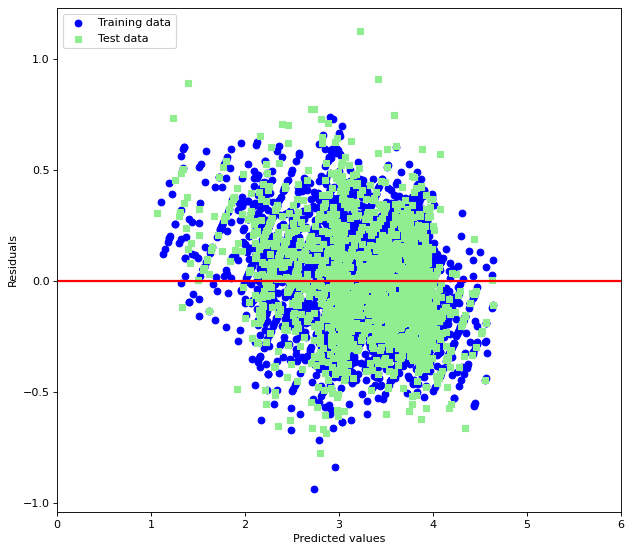

In [77]:
plt.figure(figsize=(8, 7), dpi=80)
plt.scatter(predict_train,  predict_train - target_train,
            c='blue', marker='o', label='Training data')
plt.scatter(predict_test,  predict_test - target_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([0, 6])
plt.tight_layout()

В целом оценка прогнозируется достаточно прилично. Ближе к центру значения хорошо наслаиваются друг на друга. Тем не менее, нельзя не отметить ряд выбросов на тесте (см. верхняя часть диаграммы).

Теперь перейдем к последней задаче: порекомендуем фильмы нашему юзеру на основе его оценок. Для этого посмотрим, какие фильмы он оценил достаточно высоко и отфильтруем датасет по ним (т.е. немного перепишем функцию):

In [78]:
def users_max_rating(number):
    lst_of_movies = ratings[ratings['userId'] == number]['movieId'].tolist() 

    all_feat = pd.concat([feat_train, feat_test])    
    
    all_targ = ratings[ratings['userId'] == user][['movieId', 'rating']]
    all_targ = all_targ.set_index('movieId')
    target_tt = all_targ['rating'].sort_values(ascending=False)[:5] #выберем 10 фильмов с самой высокой оценкой по версии юзера
        
    test_df = all_feat.query('index in @target_tt.index')
    test_df[['median', 'var', 'count_nonzero']] = 0  #занулим первые столбцы, т.к. они перетягивают на себя веса при поиске подходящего фильма
        
    return test_df, target_tt

In [79]:
user = int(input("Введите номер пользователя: "))

Введите номер пользователя: 117


In [80]:
fea, tar = users_max_rating(user)
fea.shape, tar.shape

((5, 754), (5,))

In [81]:
fea

,median,var,count_nonzero,0,1,2,3,4,5,6,...,721,722,723,724,725,726,727,728,729,730
movieId,,,,,,,,,,,,,,,,,,,,,
593,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.583653,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,0.0,0.0,0.0,0.483923,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.857606,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
527,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Найдем, что за фильмы:

In [82]:
movies.query('movieId in @fea.index')

,movieId,title,genres
97,110,Braveheart (1995),Action|Drama|War
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
428,491,"Man Without a Face, The (1993)",Drama
461,527,Schindler's List (1993),Drama|War
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller


Дальше напишем функцию, вычисляющую ближайших соседей и выдающую подборку из 10 фильмов, которые теоретически могут понравиться юзеру:

In [83]:
def return_recommend(df_train):
    result = neigh.kneighbors(df_train, return_distance=True)
    df_result = pd.DataFrame(columns=['movieId', 'title', 'genres'])    # вернем подборку фильмов в виде фрейма
    for i in result[1][0]:
        for j in movies.index:   # опираться будем на new_movies как на основной датафрейм
            if i == j:           
                df_result = df_result.append({'movieId': new_movies['movieId'][i],
                            'title': new_movies['title'][i],
                            'genres': new_movies['genres'][i]
                            }, ignore_index=True)

    return df_result

In [84]:
return_recommend(fea)

,movieId,title,genres
0,5248,Smokey and the Bandit III (1983),Action|Comedy
1,519,RoboCop 3 (1993),Action|Crime|Drama|Sci-Fi|Thriller
2,3452,Romeo Must Die (2000),Action|Crime|Romance|Thriller
3,277,Miracle on 34th Street (1994),Drama
4,377,Speed (1994),Action|Romance|Thriller
5,4625,Millennium (1989),Drama|Sci-Fi|Thriller
6,4409,Shadows and Fog (1991),Comedy|Drama|Mystery|Thriller
7,6217,"Safety of Objects, The (2001)",Drama
8,969,"African Queen, The (1951)",Adventure|Comedy|Romance|War
9,539,Sleepless in Seattle (1993),Comedy|Drama|Romance


Интересно, что на первом месте в подборке рекомендаций выпал фильм жанров экшн и комедия (хотя экшн этот пользователь действительно смотрит. Довольно непредсказуемый ближайший сосед). Далее уже подобраны фильмы несколько ближе, чем первый. В каждом из них присутствует какой-либо жанр (или несколько), что так полюбились пользователю. Действительно, есть вероятность, что хотя бы один фильм из этой подборки получит высокую оценку.

Попробуем для 12 пользователя:

In [85]:
user = int(input("Введите номер пользователя: "))
fea, tar = users_max_rating(user)
movies.query('movieId in @fea.index')

Введите номер пользователя: 12


,movieId,title,genres
189,222,Circle of Friends (1995),Drama|Romance
1045,1357,Shine (1996),Drama|Romance
1291,1721,Titanic (1997),Drama|Romance
6058,40629,Pride & Prejudice (2005),Drama|Romance
6905,63992,Twilight (2008),Drama|Fantasy|Romance|Thriller


In [86]:
return_recommend(fea)

,movieId,title,genres
0,1518,Breakdown (1997),Action|Thriller
1,1357,Shine (1996),Drama|Romance
2,3865,"Original Kings of Comedy, The (2000)",Comedy|Documentary
3,4219,Girls Just Want to Have Fun (1985),Comedy
4,2124,"Addams Family, The (1991)",Children|Comedy|Fantasy
5,34523,The Chumscrubber (2005),Comedy|Drama
6,3461,Lord of the Flies (1963),Adventure|Drama|Thriller
7,3033,Spaceballs (1987),Comedy|Sci-Fi
8,5099,Heidi (1937),Children|Drama
9,665,Underground (1995),Comedy|Drama|War


Любопытно. Этот пользователь любит драмы и романтические фильмы, но помимо них в подборке участвуют еще несколько фильмов для детской аудитории. Виной тому посмотренные один раз "Сумерки". Собственно, из-за них и триллеры несколько раз мелькают в подборке. Хотя... может, и понравится?

И последний:

In [87]:
user = int(input("Введите номер пользователя: "))
fea, tar = users_max_rating(user)
movies.query('movieId in @fea.index')

Введите номер пользователя: 500


,movieId,title,genres
1322,1784,As Good as It Gets (1997),Comedy|Drama|Romance
2259,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2508,3355,"Ninth Gate, The (1999)",Fantasy|Horror|Mystery|Thriller
3194,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...


In [88]:
return_recommend(fea)

,movieId,title,genres
0,26524,"Times of Harvey Milk, The (1984)",Documentary
1,345,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
2,3573,Carnosaur 2 (1995),Horror|Sci-Fi
3,5679,"Ring, The (2002)",Horror|Mystery|Thriller
4,2640,Superman (1978),Action|Adventure|Sci-Fi
5,2841,Stir of Echoes (1999),Horror|Mystery|Thriller
6,2597,Lost & Found (1999),Comedy|Romance
7,269,My Crazy Life (Mi vida loca) (1993),Drama
8,5670,Comedian (2002),Comedy|Documentary
9,4738,Happy Accidents (2000),Romance|Sci-Fi


Вкус 147 пользователя весьма разносторонний, но модель всё же подобрала вероятно интересные фильмы. 

### Вывод

Цель данной работы - построить модель рекомендательной системы для подбора конкретному пользователю фильмов, которые он предположительно может высоко оценить.  
Работа состояла из нескольких этапов:  
На первом этапе мы анализировали данные, искали зависимости и предобрабатывали датасеты.  
На втором этапе мы сгенерировали несколько новых признаков и объединили таблицы в одну.  
Следующим шагом стало TF-IDF-преобразование текстовых фичей с последующим объединением этих фичей и сгенерированных признаков.  
На этапе обучения модели перед нами ставились 2 задачи: предсказать среднюю оценку фильму и сделать подборку фильмов для конкретного пользователя. Нами была выбрана модель KNeighborsRegressor, которая показала достаточно хорошие результаты при предсказании средней оценки фильма. Далее эта же модель использоваталсь для предложения юзеру 15 фильмов, рекомендуемых к просмотру на основе уже оцененных им фильмов.  
По результату подбора ряда фильмов нескольким пользователям можно сделать вывод, что модель действительно подбирает схожие по жанру, тегу или по оценке фильмы.  
Цель работы достигнута.